In [1]:
##--------------------------------------------------------------------------------
## Summary : classify hand written digits using simple CNN,Pretty Tensor&use saver
## Author  : Venkata Srinivas Vemprala
## SourceCode : https://github.com/Hvass-Labs/TensorFlow-Tutorials
##--------------------------------------------------------------------------------

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import prettytensor as pt

from sklearn.metrics import confusion_matrix

In [2]:
## Importing the handwritten data from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
##Declaring constants
img_size = 28
img_shape = (img_size,img_size)
img_size_flat = img_size * img_size
num_classes = 10
batch_size = 100

trueLabelsTrain = np.array([label.argmax() for label in data.train.labels])
trueLabelsTest = np.array([label.argmax() for label in data.test.labels])
trueLabelsValidation = np.array([label.argmax() for label in data.validation.labels])

In [4]:
## Declaring function to plot images
def plotImages(images,trueLabels,predLabels=None):
    assert len(images) == len(trueLabels) == 9
    
    #create a 3x3 subplot
    (fig,axes) = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        if predLabels==None:
            xlabel = 'True : '+str(trueLabels[i])
        else : 
            xlabel = 'True : '+str(trueLabels[i])+' Pred : '+str(predLabels[i])
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

In [5]:
##lets write a function to print weights
def printConfMatrix(trueLabels,predLabels):
    cm = confusion_matrix(y_true=trueLabels,y_pred=predLabels)
    print(cm)

##Function to print wrong examples    
def printExampleErrors(images,trueLabels,predLabels):
    correct = np.equal(trueLabels,predLabels)
    indexes = np.where(correct==False)
    
    incorrectImages = images[indexes]
    incorrectTrueLabels = trueLabels[indexes]
    incorrectPredLabels = predLabels[indexes]
    plotImages(incorrectImages[0:9],incorrectTrueLabels[0:9],incorrectPredLabels[0:9])

In [6]:
##lets write a function to plot conv weights
def plotConvWeights(weights,inputChannel=0):
    ##find max and min of weights
    w_max = np.max(weights)
    w_min = np.min(weights)
    
    ##lets get number of weights to plot
    numFilters = weights.shape[3]
    
    ##lets get number of images per axis
    numGrids = math.ceil(math.sqrt(numFilters))
    
    (fig,axes) = plt.subplots(numGrids,numGrids)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,ax in enumerate(axes.flat):
        ##Remove the axes where there are no filters
        if i<numFilters:
            image = weights[:,:,inputChannel,i]
            ax.imshow(image,vmax=w_max,vmin=w_min,interpolation='nearest', cmap='seismic')
            ax.set_xlabel('Filter : '+str(i))
        
            #remove ticks
            ax.set_xticks([])
            ax.set_yticks([])

In [7]:
##lets create the graph

##Input PlaceHolders
x = tf.placeholder(tf.float32,shape=[None,img_size_flat])
y_true = tf.placeholder(tf.float32,shape=[None,num_classes])

## We are passing the image to cnn so need to resize it 
x_image = tf.reshape(x,[-1,img_size,img_size,1])

##Pretty Tensor
x_pretty = pt.wrap(x_image)

##Model declaration
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred,loss = x_pretty.conv2d(kernel=5,depth=10,name='layer1').max_pool(kernel=2,stride=2).\
            conv2d(kernel=5,depth=24,name='layer2').max_pool(kernel=2,stride=2).\
            flatten().fully_connected(size=128,name='layerfc').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

##accuracy
correct = tf.equal(tf.argmax(y_pred,dimension=1),tf.argmax(y_true,dimension=1))
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

##Optimization
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [8]:
##Lets write a function to get the weights from this pretty tensor

# Retrieve an existing variable named 'weights' in the scope
# with the given layer_name.
def getWeights(layerName):
    with tf.variable_scope(layerName,reuse=True):
        variable = tf.get_variable('weights')
        
    return variable

In [9]:
weights1 = getWeights('layer1')
weights2 = getWeights('layer2')

In [10]:
## lets start running the graph
session = tf.Session()
session.run(tf.global_variables_initializer())

def runOptimization(numIter):
    for i in range(0,numIter):
        batchSize = 100
        startTime = time.time()
        numIterations = int(len(data.train.labels)/batchSize)
        
        for j in range(0,numIterations):
            [x_batch,y_batch] = data.train.next_batch(batch_size)
            
            feed = {x:x_batch,y_true:y_batch}
            session.run(optimizer,feed_dict=feed)
            
        labelsTrain = session.run(y_pred,feed_dict={x:data.train.images,y_true:data.train.labels})
        labelsTest = session.run(y_pred,feed_dict={x:data.test.images,y_true:data.test.labels})
        w1 = session.run(weights1,feed_dict={x:data.train.images,y_true:data.train.labels})
        w2 = session.run(weights2,feed_dict={x:data.train.images,y_true:data.train.labels})
        
        accuracyTrain = session.run(accuracy,feed_dict={x:data.train.images,y_true:data.train.labels})
        accuracyTest = session.run(accuracy,feed_dict={x:data.test.images,y_true:data.test.labels})
        
        print('Iteration ',str(i),':')
        print('Time Taken : ',str(time.time()-startTime),'seconds')
        print('Training accuracy : ',accuracyTrain*100)
        print('Testing accuracy : ',accuracyTest*100)
        
    return labelsTrain,labelsTest,w1,w2

In [11]:
labelsTrain,labelsTest,w1,w2 = runOptimization(2)

Iteration  0 :
Time Taken :  151.80907678604126 seconds
Training accuracy :  96.6690897942
Testing accuracy :  96.8400001526
Iteration  1 :
Time Taken :  162.1532940864563 seconds
Training accuracy :  98.1581807137
Testing accuracy :  98.0099976063


In [12]:
printConfMatrix(np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

[[5332    1   13    5    1    5   52    1   29    5]
 [   0 6138   11    6    7    0    2    8    7    0]
 [   1    8 5387   28    6    1    4   14   20    1]
 [   1    1    8 5596    0    6    2    6   15    3]
 [   0   11    3    1 5267    0   14    2    4    5]
 [   4    1    0   78    3 4814   42    1   39    5]
 [   2    5    1    1    4    1 5392    0   11    0]
 [   1   10   16   21   21    1    0 5611   12   22]
 [   2   15   11   37   11    9    8    2 5285    9]
 [  11    9    3   95  101    7    3   23   37 5165]]


/home/srvv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


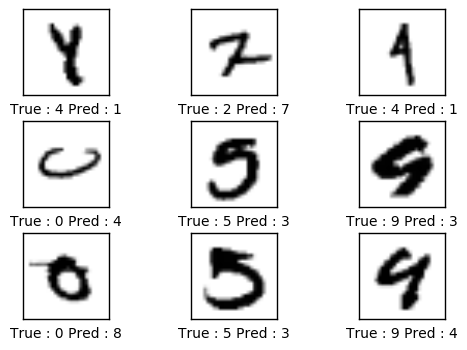

In [13]:
## lets print example errors
printExampleErrors(data.train.images,np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

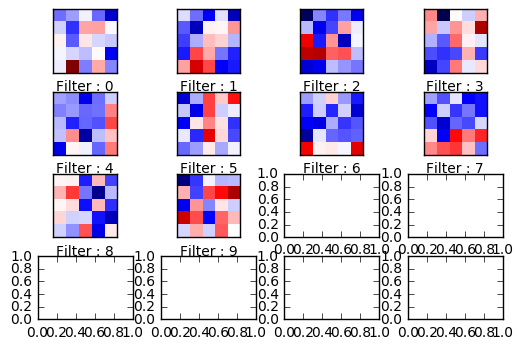

In [14]:
plotConvWeights(w1)

In [15]:
## Now lets run some more iterations
labelsTrain,labelsTest,w1,w2 = runOptimization(8)

Iteration  0 :
Time Taken :  150.4067873954773 seconds
Training accuracy :  98.7963616848
Testing accuracy :  98.4600007534
Iteration  1 :
Time Taken :  151.74099159240723 seconds
Training accuracy :  98.9581823349
Testing accuracy :  98.5199987888
Iteration  2 :
Time Taken :  152.23962140083313 seconds
Training accuracy :  99.3272721767
Testing accuracy :  98.9099979401
Iteration  3 :
Time Taken :  156.9946732521057 seconds
Training accuracy :  99.407273531
Testing accuracy :  98.8900005817
Iteration  4 :
Time Taken :  155.56453466415405 seconds
Training accuracy :  99.4090914726
Testing accuracy :  98.7999975681
Iteration  5 :
Time Taken :  150.76358318328857 seconds
Training accuracy :  99.5872735977
Testing accuracy :  98.9000022411
Iteration  6 :
Time Taken :  157.16866302490234 seconds
Training accuracy :  99.707275629
Testing accuracy :  99.0400016308
Iteration  7 :
Time Taken :  157.15836358070374 seconds
Training accuracy :  99.6090888977
Testing accuracy :  98.9400029182


In [16]:
printConfMatrix(np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

[[5430    0    6    2    0    0    1    0    5    0]
 [   0 6134   13    4    7    1    0    7    6    7]
 [   0    0 5466    0    0    1    0    1    2    0]
 [   0    0    3 5626    0    2    0    1    5    1]
 [   0    0    1    0 5299    0    2    1    0    4]
 [   0    0    1    3    0 4983    0    0    0    0]
 [   2    1    2    0    1   19 5390    0    2    0]
 [   0    1   26    4    2    0    0 5647    5   30]
 [   0    1    1    1    0   11    0    0 5370    5]
 [   1    1    0    2    5    3    0    2    0 5440]]


/home/srvv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


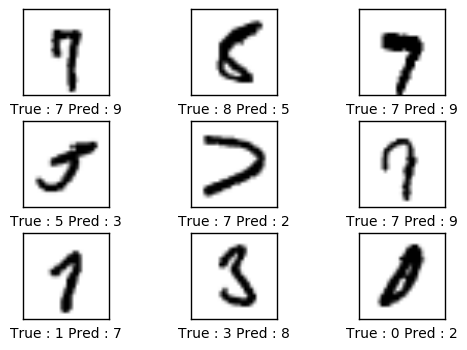

In [17]:
## lets print example errors
printExampleErrors(data.train.images,np.argmax(data.train.labels,axis=1),np.argmax(labelsTrain,axis=1))

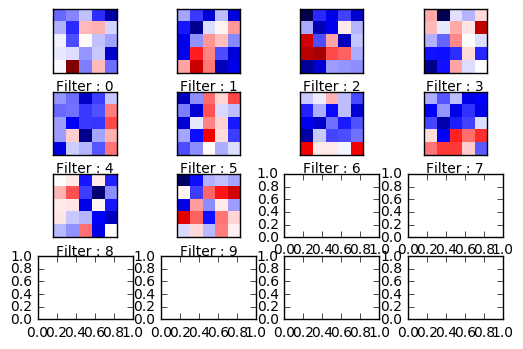

In [18]:
plotConvWeights(w1)

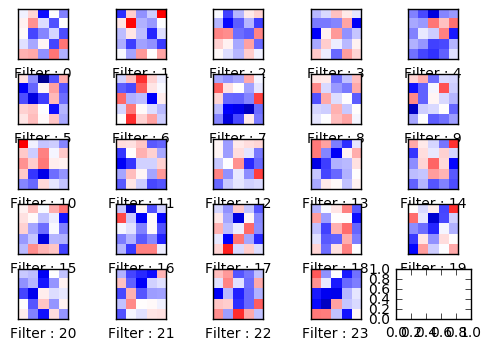

In [19]:
plotConvWeights(w2)